In [2]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sys
sys.path.append('../')
sys.path.append('../utils/')
sys.path.append('../brisque')
import imquality.brisque as brisque
from brisque import BRISQUE
from test_model import mean_absolute_percentage_error as mape

import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [3]:
with open('label_with_brisk_features_map.pickle', 'rb') as f:
    imgs = pickle.load(f)

In [4]:
X = [imgs[img][1] for img in imgs]
Y = [imgs[img][0] for img in imgs]


In [9]:
import pandas as pd


In [11]:
pd.DataFrame(X).describe()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
count,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,...,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000,1053.000000
mean,1.186168,0.046836,0.395806,0.023951,0.002239,0.010755,0.434783,0.000424,0.005287,0.005480,...,0.009821,0.009862,0.447852,-0.002230,0.010354,0.007754,0.446693,-0.001295,0.010111,0.007899
std,0.115827,0.025676,0.050673,0.016440,0.003873,0.009098,0.031772,0.007374,0.004804,0.006852,...,0.008555,0.009185,0.051263,0.014897,0.009962,0.005657,0.051642,0.014419,0.009739,0.005745
min,0.981000,0.021092,0.320000,0.000646,0.000883,0.001057,0.380000,-0.008290,0.000944,0.001005,...,0.000914,0.002186,0.367000,-0.021622,0.000868,0.001963,0.365000,-0.019835,0.000838,0.001959
25%,1.096000,0.026070,0.356000,0.007754,0.001024,0.002398,0.412000,-0.006234,0.001182,0.001741,...,0.001419,0.004396,0.408000,-0.015088,0.001628,0.003423,0.407000,-0.013878,0.001609,0.003436
50%,1.185000,0.046876,0.382000,0.029555,0.001145,0.013087,0.426000,0.000338,0.006166,0.004090,...,0.013126,0.008203,0.433000,-0.012573,0.012540,0.007142,0.432000,-0.010815,0.012304,0.007345
75%,1.240000,0.055567,0.439000,0.038604,0.001235,0.015973,0.449000,0.003220,0.007284,0.005412,...,0.015071,0.009903,0.487000,0.008457,0.014868,0.008583,0.486000,0.008689,0.014427,0.008839
max,1.510000,0.129581,0.503000,0.049697,0.017500,0.035883,0.514000,0.020834,0.020418,0.031660,...,0.032129,0.043097,0.559000,0.029781,0.040487,0.027361,0.557000,0.029761,0.039961,0.028184


Применим PCA, посмотрим на важность фичей

In [12]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)


In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [15]:
pca.explained_variance_ratio_

array([5.51370532e-01, 3.63229501e-01, 5.43097750e-02, 2.68486550e-02,
       2.17692213e-03, 8.57988226e-04, 4.94115394e-04, 2.59867934e-04,
       1.01556155e-04, 8.36156639e-05, 6.69578807e-05, 4.67235290e-05,
       3.72588899e-05, 2.44912438e-05, 2.27230729e-05, 1.75461784e-05,
       1.19807328e-05, 7.21955617e-06, 6.16471048e-06, 5.87801723e-06,
       4.85616980e-06, 3.30225976e-06, 3.06403071e-06, 2.72318063e-06,
       1.99767006e-06, 1.22348798e-06, 9.06098079e-07, 7.57694438e-07,
       6.28143370e-07, 2.85002134e-07, 2.26633486e-07, 1.78090667e-07,
       1.54182643e-07, 1.12416449e-07, 8.18613785e-08, 3.04346590e-08])

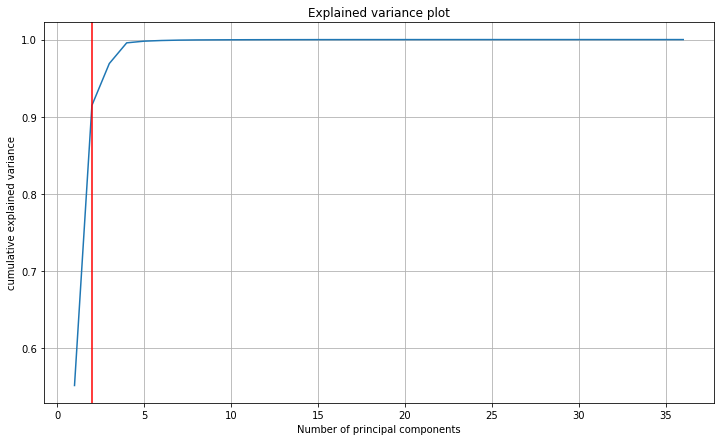

In [16]:
plt.figure(figsize = (12, 7))
plt.xlabel('Number of principal components')
plt.ylabel('cumulative explained variance')
plt.title('Explained variance plot')
plt.plot(np.arange(pca.n_components_) + 1, np.cumsum(pca.explained_variance_ratio_))
plt.axvline(2, c = 'r')
plt.grid()
plt.show()

#### Видим, что подходящее число компонент - 5

Попробуем визуализировать

In [18]:
pca = PCA(n_components=2)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [19]:
X_reduced = pca.transform(X_scaled)
X_reduced.shape

(1053, 2)

In [20]:
from collections import Counter
Counter(Y)

Counter({70: 324, 30: 324, 50: 324, 5: 81})

In [21]:
X5 = []
X30 = []
X50 = []
X70 = []

for i in range(len(X_reduced)):
    if Y[i] == 5:
        X5.append(list(X_reduced[i]))
    if Y[i] == 30:
        X30.append(X_reduced[i])
    if Y[i] == 50:
        X50.append(X_reduced[i])  
    if Y[i] == 70:
        X70.append(X_reduced[i]) 
X5 = np.array(X5)
X30 = np.array(X30)
X50 = np.array(X50)
X70 = np.array(X70)

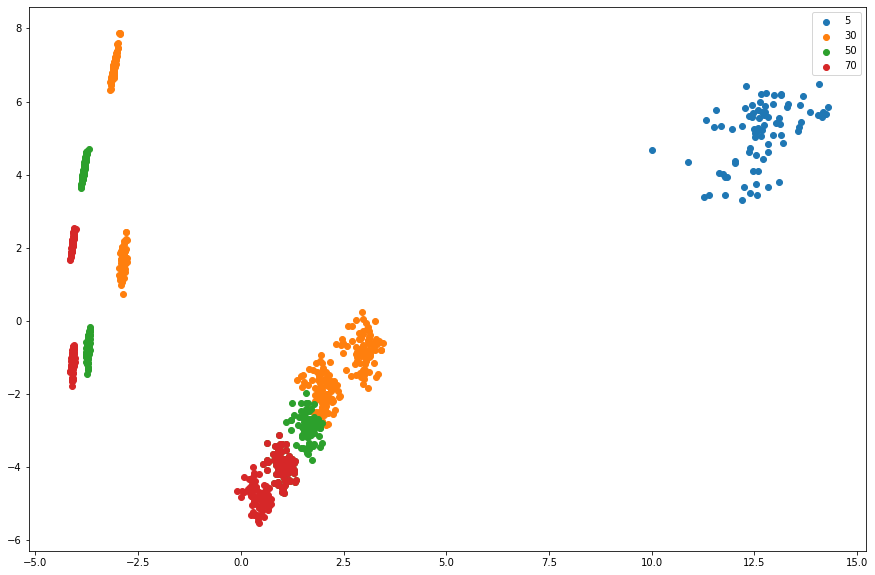

In [22]:
plt.figure(figsize=(15, 10))
plt.scatter(X5[:, 0], X5[:, 1], label = '5')
plt.scatter(X30[:, 0], X30[:, 1], label = '30')
plt.scatter(X50[:, 0], X50[:, 1], label = '50')
plt.scatter(X70[:, 0], X70[:, 1], label = '70')

plt.legend()


Видим, что модели , которые строят не линейные разделяющие поверхности должны хорошо справляться с такими данными